In [12]:
!pip install -r requirements.txt

  Using cached pandas-1.5.3-cp310-cp310-macosx_10_9_x86_64.whl.metadata (11 kB)
  Using cached langchain-0.2.6-py3-none-any.whl.metadata (7.0 kB)
Using cached pandas-1.5.3-cp310-cp310-macosx_10_9_x86_64.whl (12.0 MB)
Using cached langchain-0.2.6-py3-none-any.whl (975 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 225.2 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.0.92
    Uninstalling langsmith-0.0.92:
      Successfully uninstalled langsmith-0.0.92
  Attempting uninstall: langchain
    Found existing installation: langchain 0.0.309
    Uninstalling langchain-0.0.309:
      Successfully uninstalled langchain-0.0.309


### <font color='red'>Setup</font> 
---
<font color='red'>⚠️ ⚠️ ⚠️</font> 
Before running this notebook, ensure you've run the [Set-Up Bedrock notebook](./set-up_bedrock.ipynb) notebook. <font color='red'>⚠️ ⚠️ ⚠️</font>

---

## Configure Bedrock

Create the necessary clients to invoke Bedrock models. If you need to pass in a certain role then set those values by uncommenting the section below.

First we instantiate using Anthropic Claude V2 for text generation, and Titan Embeddings G1 - Text for text embeddings.

Note: Many different models are available with Bedrock. Replace the `model_id` to change the model.

`llm = Bedrock(model_id="anthropic.claude-v2")`

Information on available model IDs [here](https://docs.aws.amazon.com/bedrock/latest/userguide/model-ids-arns.html)

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [388]:
import json
import os
import sys
import boto3
import botocore

from langchain.llms.bedrock import Bedrock
from IPython.display import Image

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

os.environ["AWS_DEFAULT_REGION"] = "us-east-1"
# os.environ["AWS_PROFILE"] = ""
# os.environ["BEDROCK_ASSUME_ROLE"] = ""  # E.g. "arn:aws:..."

boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=False)

bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None))

model_parameter = {
    "temperature": 0.0, 
    "top_p": .5, 
    "top_k": 250, 
    "max_tokens_to_sample": 2000, 
    "stop_sequences": ["\n\n Human: bye"]
}
llm = Bedrock(
    model_id="anthropic.claude-v2", 
    model_kwargs=model_parameter, 
    client=bedrock_runtime
)

Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock(https://bedrock.us-east-1.amazonaws.com)
Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


## Implementation
This notebook is using the LangChain framework where it has integrations with different services and the following tools:

- **LLM (Large Language Model)**: Anthropic Claude V2 available through Amazon Bedrock

  This model will be used to understand the document chunks and provide an answer in human friendly manner.
- **Embeddings Model**: Amazon Titan Embeddings available through Amazon Bedrock

  This model will be used to generate a numerical representation of the textual documents
- **Document Loader**: [S3FileLoader](https://api.python.langchain.com/en/latest/document_loaders/langchain.document_loaders.s3_file.S3FileLoader.html) and PDF Loader available through LangChain

  This is the loader that can load the documents from a source, for the sake of this notebook we are loading the sample files from a local path. This could easily be replaced with a loader to load documents from enterprise internal systems.

- **Vector Store**: In-Memory store FAISS

  The index helps to compare the input embedding and the document embeddings to find relevant document
- **Wrapper**: wraps index, vector store, embeddings model and the LLM to abstract away the logic from the user.

In [15]:
#TEST
customer_input = "I am  looking for a fan for our warehouses that will be energy efficient and assist with air circulation for the large open indoor warehouse. I need to be able to purchase in bulk for several locations in Indiana."


# Customer id to infuse order history and delivery address
customer_id = "2"

In [16]:
# Identify product attributes from customer prompt to generate better results
ner_prompt = """Human: Find industry, size, Sustainability Focus, Inventory Manager, and the location in the customer input.
Instructions:
The industry can be one of the following: Manufacturing, Warehousing, Government and Public Safety, Education, Food and Beverage Distribution, Hospitality, Property Management, Retail, or Other
The size can be one of the following: Small Businesses (Smaller companies might prioritize cost-effective solutions and fast shipping options), or Large Enterprises (Larger organizations may require more comprehensive solutions, including strategic services like inventory management and safety consulting), Womens, Other
The Sustainability Focused true or false meaning Environmentally Conscious Buyers: Customers interested in sustainability solutions, looking for products that focus on energy management, water conservation, waste reduction, and air quality improvement, or NOT Environmentally Conscious Buyers,
The Inventory Manager true or false meaning a purchaser in large amounts to supply an organizational group, versus an individual user purchasing for personal use, 
The output must be in JSON format inside the tags <attributes></attributes>

If the information of an entity is not available in the input then don't include that entity in the JSON output

Begin!

Customer input: {customer_input}
Assistant:"""
entity_extraction_result = llm(ner_prompt.format(customer_input=customer_input)).strip()
print(entity_extraction_result)

<attributes>
{
  "industry": "Warehousing",
  "size": "Large Enterprises", 
  "SustainabilityFocus": true,
  "InventoryManager": true,
  "location": "Indiana"
}
</attributes>


#### Extract values into JSON

In [17]:
import re
import json
result = re.search('<attributes>(.*)</attributes>', entity_extraction_result, re.DOTALL)
attributes = json.loads(result.group(1))
attributes

{'industry': 'Warehousing',
 'size': 'Large Enterprises',
 'SustainabilityFocus': True,
 'InventoryManager': True,
 'location': 'Indiana'}

## Use Retrieval Augmented Generation (RAG) 

Note: documents loaded with [S3FileLoader available under LangChain](https://python.langchain.com/docs/modules/data_connection/document_loaders/) can be split into smaller chunks. The retrieved document/text should be large enough to contain enough information to answer a question; but small enough to fit into the LLM prompt. Also the embeddings model has a limit of the length of input tokens limited to 8k tokens, which roughly translates to ~32000 characters. For the sake of this use-case we are creating chunks of roughly 1000 characters with an overlap of 100 characters using [RecursiveCharacterTextSplitter](https://python.langchain.com/en/latest/modules/indexes/text_splitters/examples/recursive_text_splitter.html).

Below: fetching our productdata and creating the embeddings for 
1. Product catalog description
2. Customer reviews

# TODO: ADD order history for authenticated user
3. Order History 

In [93]:
import pandas as pd
parquet_file_path = "processed/grainger_products.parquet"
print("Attempting to load file from:", parquet_file_path)

# Now attempt to load the file
try:
    df = pd.read_parquet(parquet_file_path)
    print("File loaded successfully!")
except FileNotFoundError as e:
    print("Error loading file:", e)

print(df.head())

Attempting to load file from: processed/grainger_products.parquet
File loaded successfully!
                          Brand    Code  \
0  LION FIRE BOOTS BY THOROGOOD   3XRG7   
1           GLOWEAR BY ERGODYNE   1CXK5   
2                      CARHARTT  491V68   
3                      TRIPLETT  794UC5   
4                        DEWALT  492U19   

                                                Name  \
0  Insulated Firefighter Boots: Insulated, Steel,...   
1  GLOWEAR BY ERGODYNE Baseball Cap: Orange, Univ...   
2  CARHARTT Bib Overalls: Men's, XL ( 42 in x 32 ...   
3  TRIPLETT Combustible Gas Detector: Audible/Vib...   
4  DEWALT Heated Jacket: Men's, S, Black, Up to 9...   

                                       PictureUrl600    Price  \
0  https://static.grainger.com/rp/s/is/image/Grai...  $197.55   
1  https://static.grainger.com/rp/s/is/image/Grai...   $13.93   
2  https://static.grainger.com/rp/s/is/image/Grai...   $95.79   
3  https://static.grainger.com/rp/s/is/image/Grai...

In [ ]:
# ## Approach 1: Using Textual Columns Directly
# # To focus on text-based similarity (e.g., based on 'Name' and 'Description'), columns are concatenated
# # FAISS.from_texts is used. This allows more granular control.
# from langchain.embeddings import BedrockEmbeddings
# from langchain.vectorstores import FAISS
# import pandas as pd
# import numpy as np
# 
# # Initialize the Titan Embeddings Model
# print("Initializing Titan Embeddings Model...")
# bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrock_runtime)
# print("Titan Embeddings Model initialized.")
# 
# # Load the Grainger products data from parquet file at path relative to the notebook
# parquet_file_path = "processed/grainger_products.parquet"
# print(f"Loading data from parquet file: {parquet_file_path}...")
# products_df = pd.read_parquet(parquet_file_path)
# print("Data loaded successfully.")
# 
# # Concatenate 'Name', 'Description', and 'Code' columns
# print("Concatenating 'Name', 'Description', and 'Code' columns...")
# products_df['text_content'] = products_df['Name'].fillna('') + ' ' + products_df['Description'].fillna('') + ' ' + products_df['Code'].fillna('')
# 
# # Create FAISS vector store from concatenated text content
# print("Creating FAISS vector store based on concatenated text content...")
# vectorstore_faiss = FAISS.from_texts(products_df['text_content'], bedrock_embeddings)
# print("FAISS vector store created.")
# 
# # TEST: Process a query based on a product code
# customer_code = "1CXK5"  # Example product code to search
# print(f"Processing customer query for product with code: {customer_code}...")
# query_result = products_df[products_df['Code'] == customer_code]
# 
# if not query_result.empty:
#     print("Product details found:")
#     print(query_result)
# else:
#     print(f"No product found with code: {customer_code}")
# 
# # TEST: Process a query based on customer input
# customer_input = "Men's insulated boots"
# print(f"Processing customer input: {customer_input}...")
# query_embedding = bedrock_embeddings.embed_query(customer_input)
# print("Customer input processed.")
# 
# # Convert query embedding to numpy array
# np_array_query_embedding = np.array(query_embedding)
# print("Query embedding converted to numpy array.")
# 
# # Print the resulting query embedding
# print("Resulting query embedding:")
# print(np_array_query_embedding)


In [417]:
#VERSION 2: AS A DOCUMENT
# Automates the process and optimizes for large and changing data sets.
from langchain.embeddings import BedrockEmbeddings
from langchain.vectorstores import FAISS
import pandas as pd
import numpy as np


class Document:
    def __init__(self, page_content, metadata):
        self.page_content = page_content
        self.metadata = metadata
        
# Initialize the Titan Embeddings Model
print("Initializing Titan Embeddings Model...")
bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client=bedrock_runtime)
print("Titan Embeddings Model initialized.")

documents = []
for _, row in df.iterrows():
    page_content = f"{row['Code']} {row['Name']} {row['Brand']} {row['Description'] if pd.notna(row['Description']) else ''}"
    metadata = {
        'Brand': row['Brand'],
        'Code': row['Code'],
        'Name': row['Name'],
        'Description': row['Description'],
        'Price': row['Price']
    }
    documents.append(Document(page_content, metadata))


# Print the structured documents
print("Structured documents created:")
for idx, doc in enumerate(documents[:5], 1):  
    print(f"Document {idx} of {len(documents)}:")
    print(doc.page_content[:200])
    print()

# Create FAISS vector store from structured documents
print("Creating FAISS vector store from structured documents...")
vectorstore_faiss_doc = FAISS.from_documents(documents, bedrock_embeddings)
print("FAISS vector store created.")


customer_input = "Men's insulted boots."
query_embedding_doc = bedrock_embeddings.embed_query(customer_input)
print("Customer input processed.")

# Convert query embedding to numpy array
np_array_query_embedding_doc = np.array(query_embedding_doc)
print("Query embedding converted to numpy array.")

# Print the resulting query embedding
print("Resulting query embedding:")
print(np_array_query_embedding_doc)


Initializing Titan Embeddings Model...
Titan Embeddings Model initialized.
Structured documents created:
Document 1 of 1736:
3XRG7 Insulated Firefighter Boots: Insulated, Steel, 10-1/2, M, Structural, 1 PR LION FIRE BOOTS BY THOROGOOD <p>Thorogood® 807-6003 Insulated Boots are designed for use by firefighters in demanding a

Document 2 of 1736:
1CXK5 GLOWEAR BY ERGODYNE Baseball Cap: Orange, Universal, Baseball Hat Hat, Polyester, Gen Purpose GLOWEAR BY ERGODYNE <p>Baseball hats have a curved brim that shades the eyes from sun to reduce eye 

Document 3 of 1736:
491V68 CARHARTT Bib Overalls: Men's, XL ( 42 in x 32 in ), Navy, Cotton, Zipper, Zipper, 9 Pockets CARHARTT <p>Overalls (sometimes called bib overalls) are sleeveless garments that cover the torso and

Document 4 of 1736:
794UC5 TRIPLETT Combustible Gas Detector: Audible/Vibration/Visual Indicator, Rechargeable Li-Po Battery TRIPLETT 

Document 5 of 1736:
492U19 DEWALT Heated Jacket: Men's, S, Black, Up to 9 hr, 36 in Max Chest

In [ ]:
## Going forward the FAISS.from_document version is used

In [185]:
# ## USING SELENIUM
# 
# # import asyncio
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from webdriver_manager.chrome import ChromeDriverManager
# import pandas as pd
# import time
# 
# # df_path = 'processed/grainger_products.parquet'
# # df = pd.read_parquet(df_path)
# 
# 
# async def get_images(recommendations_list):
#     options = Options()
#     options.add_argument("--headless")
#     options.add_argument("--disable-gpu")
#     service = Service(ChromeDriverManager().install())
#     driver = webdriver.Chrome(service=service, options=options)
# 
#     image_tasks = []
#     image_urls = []
#     total_image_time = 0.0
# 
#     for item in recommendations_list:
#         # Split the recommendation string to get text and code
#         parts = item.split(', ')
#         code = parts[-1]  # Code is the last element
#         text = ', '.join(parts[:-1])  # Text is everything except the code
# 
#         if code in df['Code'].values:
#             start_time = time.time()
#             image_url = df.loc[df['Code'] == code, 'PictureUrl600'].iloc[0]
#             end_time = time.time()
#             total_image_time += end_time - start_time
#             image_urls.append((code, image_url))
#             print(f"Fetched image URL for {code} in {end_time - start_time:.2f} seconds")
# 
#             # Add image fetching task
#             image_tasks.append(asyncio.create_task(fetch_image(code, image_url)))
#         else:
#             print(f"Code {code} not found in the dataframe.")
# 
#     # Gather all image tasks concurrently
#     image_results = await asyncio.gather(*image_tasks)
# 
#     driver.quit()  # Close the webdriver instance
# 
#     return image_urls, total_image_time
# 
# async def fetch_image(code, image_url):
#     # Simulate fetching image (replace with actual fetching logic)
#     await asyncio.sleep(1)
#     return f"Image URL for {code}: {image_url}"
# 
# # Run asyncio event loop with the async function for fetching images
# image_urls, total_image_time = await get_images(recommendations)
# 
# # Print or process the image results as needed
# print("Image URLs:", image_urls)
# print("Total Image Time:", total_image_time)


Fetched image URL for 3XRG7 in 0.00 seconds
Fetched image URL for 1CXK5 in 0.00 seconds
Fetched image URL for 491V68 in 0.00 seconds
Fetched image URL for 794UC5 in 0.00 seconds
Fetched image URL for 492U19 in 0.00 seconds
Image URLs: [('3XRG7', 'https://static.grainger.com/rp/s/is/image/Grainger/3XRG3_AS05?$lgmain$'), ('1CXK5', 'https://static.grainger.com/rp/s/is/image/Grainger/1CXK5_AS04?$lgmain$'), ('491V68', 'https://static.grainger.com/rp/s/is/image/Grainger/491V38_AS01?$lgmain$'), ('794UC5', 'https://static.grainger.com/rp/s/is/image/Grainger/794UC5_1__794UC5_v1?$lgmain$'), ('492U19', 'https://static.grainger.com/rp/s/is/image/Grainger/492U19_AS01?$lgmain$')]
Total Image Time: 0.004569530487060547


In [280]:
# USING REQUESTS

import asyncio
import aiohttp
import pandas as pd
import time


# df_path = 'processed/grainger_products.parquet'
# df = pd.read_parquet(df_path)

async def get_images(recommendations_list):
    image_tasks = []
    image_urls = []
    total_image_time = 0.0

    async with aiohttp.ClientSession() as session:
        for item in recommendations_list:
            # Split the recommendation string to get text and code
            parts = item.split(', ')
            code = parts[-1]  # Code is the last element
            text = ', '.join(parts[:-1])  # Text is everything except the code

            if code in df['Code'].values:
                start_time = time.time()
                image_url = df.loc[df['Code'] == code, 'PictureUrl600'].iloc[0]
                end_time = time.time()
                total_image_time += end_time - start_time
                image_urls.append((code, image_url))
                print(f"Fetched image URL for {code} in {end_time - start_time:.2f} seconds")

                # Add image fetching task
                image_tasks.append(fetch_image(session, code, image_url))
            else:
                print(f"Code {code} not found in the dataframe.")

        # Gather all image tasks concurrently
        image_results = await asyncio.gather(*image_tasks)

    return image_urls, total_image_time

async def fetch_image(session, code, image_url):
    async with session.get(image_url) as response:
        if response.status == 200:
            await response.read()  # Simulate fetching image (you can save or process the image here)
            return f"Image URL for {code}: {image_url}"
        else:
            return f"Failed to fetch image for {code}: {image_url}"

# Run asyncio event loop with the async function for fetching images
image_urls, total_image_time = await get_images(recommendations)

# Print or process the image results as needed
print("Image URLs:", image_urls)
print("Total Image Time:", total_image_time)


Image URLs: []
Total Image Time: 0.0


## Generate *`n`* style recommendations

Make a query to embed the LLM using customer input. Using LangChain for orchestration of RAG. It also provides a framework for orchestrating RAG flows with what purpose built "chains". In this section, we will see how to be a [retrieval chain](https://python.langchain.com/docs/use_cases/question_answering/vector_db_qa) which is more comprehensive and robust than the original retrieval system we built above.

The workflow we used above follows the following process:
1. User input is received.
2. User input is queried against the vector database to retrieve the relevant products
3. Product description and chat memory are inserted into a new prompt to respond to the user input.
4. This output is fed into the stable diffusion model to return the relevant images

However, more complex methods of interacting with the user input can generate more accurate results in RAG architectures. One of the popular mechanisms which can increase accuracy of these retrieval systems is utilizing more than one call to an LLM in order to reformat the user input for more effective search to your vector database. A better workflow is described below compared to the one we already built...

1. User input is received.
2. An LLM is used to reword the user input to be a better search query for the vector database based on the chat history and product description. 
3. This could include things like condensing, rewording, addition of chat context, or stylistic changes.
4. Reformatted user input is queried against the vector database to retrieve relevant products.The reformatted user input and relevant documents are inserted into a new prompt in order to generate the new style. 
5. This is then fed into the stable diffusion model to generate the images. 

In your application the images can come from a pre canned images 

We will now build out this second workflow using LangChain below. First we need to make a prompt which will reformat the user input to be more compatible for searching of the vector database. The way we do this is by providing the chat history as well as the some basic instructions to Claude and asking it to condense the input into a single output. 

In [175]:
# More complex customer Input
customer_input = "I am looking for waterproof insulated boots for my men working on my commercial deep sea fishing boat in the arctic. Must have large sizes."
print(f"Processing customer input: {customer_input}...")
query_embedding_doc = bedrock_embeddings.embed_query(customer_input)
print("Customer input processed.")

# Convert query embedding to numpy array
np_array_query_embedding_doc = np.array(query_embedding_doc)
print("Query embedding converted to numpy array.")

# Print the resulting query embedding
print("Resulting query embedding:")
print(np_array_query_embedding_doc)


Processing customer input: I am looking for waterproof insulated boots for my men working on my commercial deep sea fishing boat in the arctic. Must have large sizes....
Customer input processed.
Query embedding converted to numpy array.
Resulting query embedding:
[-0.96484375 -0.06591797  0.02819824 ...  0.10888672 -0.5859375
 -0.55078125]


In [31]:
# from langchain_core.prompts import PromptTemplate
# from langchain.chains.retrieval_qa.base import RetrievalQA
# import time
# from PIL import Image
# from IPython import display
# from base64 import b64decode
# import base64
# import io
# import json
# import os
# import sys
# import ipywidgets as widgets
# import re
# 
# # Function to extract attributes using NER prompt
# def extract_attributes(customer_input):
#     ner_prompt = """Human: Find location, environment, and gender in the customer input.
#     The output must be in JSON format inside the tags <attributes></attributes>
#     
#     If the information of an entity is not available in the input then don't include that entity in the JSON output
#     
#     Begin!
#     
#     Customer input: {customer_input}
#     Assistant:"""
#     print("Extracting attributes...")
#     start_time = time.time()
#     entity_extraction_result = llm(ner_prompt.format(customer_input=customer_input)).strip()
#     print("Raw entity extraction result:", entity_extraction_result)
#     print(f"Attribute extraction completed in {time.time() - start_time:.2f} seconds.")
#     
#     try:
#         attributes_json = re.search(r'<attributes>(.*?)</attributes>', entity_extraction_result, re.DOTALL).group(1)
#         attributes = json.loads(attributes_json)
#         return attributes
#     except (AttributeError, json.JSONDecodeError) as e:
#         print("Error parsing attributes:", str(e))
#         return {}
# 
# attributes = extract_attributes(customer_input)
# 
# gender_map = {
#     'Womens': 'of a female ',
#     'Mens': 'of a male '
# } 
# 
# print("customer_input: ", customer_input)
# print("attributes: ", attributes)


Extracting attributes...
Raw entity extraction result: <attributes>
{"location": "arctic", 
"environment": "deep sea fishing boat",
"gender": "men"}
</attributes>
Attribute extraction completed in 1.29 seconds.
customer_input:  I am looking for waterproof insulated boots for my men working on my commercial deep sea fishing boat in the arctic. Must have large sizes.
attributes:  {'location': 'arctic', 'environment': 'deep sea fishing boat', 'gender': 'men'}


In [208]:
# from langchain.chains import RetrievalQA
# from langchain.prompts import PromptTemplate
# 
# prompt_template = """Human: Use the following pieces of context to generate 5 recommendations for the customer input at the end.
# <context>
# {context}
# </context>
# 
# Customer Input: {question}
# Each style recommendation must be inside the tags <product></product>.
# 
# Skip the preamble.
# Assistant: """
# PROMPT = PromptTemplate(
#     template=prompt_template, input_variables=["context", "question"]
# )
# 
# # Use RetrievalQA customizations for improving Q&A experience
# qa = RetrievalQA.from_chain_type(
#     llm=llm,
#     chain_type="stuff",
#     retriever=vectorstore_faiss_doc.as_retriever(
#         search_type="similarity", search_kwargs={"k": 6}
#     ),
#     return_source_documents=False,
#     chain_type_kwargs={"prompt": PROMPT},
# )
# recs_response = qa({"query": customer_input})['result']
# recs_response

' <product>21A652 Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR THE ORIGINAL MUCK BOOT CO.</product>\n\n<product>21A650 Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 11, 1 PR THE ORIGINAL MUCK BOOT CO.</product>\n\n<product>21A649 Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 10, 1 PR THE ORIGINAL MUCK BOOT CO.</product>\n\n<product>35GU61 Rubber Boot: Rigid Fiberglass, Rubber/Rubber Over Neoprene, Black, LACROSSE, 7, 1 PR LACROSSE</product>\n\n<product>35GU62 Rubber Boot: Rigid Fiberglass, Rubber/Rubber Over Neoprene, Black, LACROSSE, 8, 1 PR LACROSSE</product>'

In [262]:
## GET LIST OF PRODUCTS AND CODES
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
prompt_template2 = """Human: Extract list of 5 products and their respective physical IDs from catalog that matches the style given below. 
The catalog of products is provided under <catalog></catalog> tags below.
<catalog>
{context}
</catalog>
Style: {question}

The output should be a json of the form <products>[{{"product": <description of the product from the catalog>, "code":<code of the product from the catalog>}}, ...]</products>
Skip the preamble and always return valid json.
Assistant: """
PROMPT = PromptTemplate(
    template=prompt_template2, input_variables=["context", "question"]
)

# Use RetrievalQA customizations for improving Q&A experience
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore_faiss_doc.as_retriever(
        search_type="similarity", search_kwargs={"k": 6}
    ),
    return_source_documents=False,
    chain_type_kwargs={"prompt": PROMPT},
)

recs_response = qa({"query": customer_input})['result']
recs_response

' <products>\n[\n  {"product": "Tethered Ball Pein Hammer: Fiberglass, Steel, 16 oz Head Wt, 1 1/8 in Face Dia, 13 in Overall Lg", "code": "24AK53"},\n  {"product": "Delineator Post: Portable, Orange, 45 in Overall Ht, Grabber Top, High-Intensity Prismatic, Nestable", "code": "1EKU7"}, \n  {"product": "Delineator Post: Portable, Orange, 45 in Overall Ht, Flat Top, High-Intensity Prismatic, Nestable", "code": "3UTR3"},\n  {"product": "Steel Engineering Hammer: Fiberglass Handle, 3 lb Head Wt, 1 3/4 in Dia, 14 in Overall Lg", "code": "2DBT7"},\n  {"product": "Hammer: Fiberglass, Steel, 12 oz Head Wt, 1 in Face Dia, 12 in Overall Lg, Textured Grip", "code": "53CT46"}\n]\n</products>'

In [302]:
# PROCESS THE RESPONSE TO JSON

import json


# Ensure recs_response is handled correctly
recs_response = recs_response.strip()  # Remove leading/trailing whitespace
response_json = ""

# Check if the response starts and ends with expected JSON markers
if recs_response.startswith("<products>") and recs_response.endswith("</products>"):
    json_content = recs_response[len("<products>") : -len("</products>")].strip()
    
    try:
        parsed_response = json.loads(json_content)
        
        if isinstance(parsed_response, list):
            products_list = []
            for product_info in parsed_response:
                # Assuming product_info is a dictionary with 'product' and 'code' keys
                product_data = {
                    "product": product_info.get("product", ""),
                    "code": product_info.get("code", "")
                }
                products_list.append(product_data)
            
            response_json = {"products": products_list}
            print(response_json)
        else:
            print("Error: Unexpected format of parsed response")
    
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {str(e)}")
else:
    print("Error: Unexpected format of recs_response")



{'products': [{'product': 'Tethered Ball Pein Hammer: Fiberglass, Steel, 16 oz Head Wt, 1 1/8 in Face Dia, 13 in Overall Lg', 'code': '24AK53'}, {'product': 'Delineator Post: Portable, Orange, 45 in Overall Ht, Grabber Top, High-Intensity Prismatic, Nestable', 'code': '1EKU7'}, {'product': 'Delineator Post: Portable, Orange, 45 in Overall Ht, Flat Top, High-Intensity Prismatic, Nestable', 'code': '3UTR3'}, {'product': 'Steel Engineering Hammer: Fiberglass Handle, 3 lb Head Wt, 1 3/4 in Dia, 14 in Overall Lg', 'code': '2DBT7'}, {'product': 'Hammer: Fiberglass, Steel, 12 oz Head Wt, 1 in Face Dia, 12 in Overall Lg, Textured Grip', 'code': '53CT46'}]}


In [242]:
# # Prepare input to fetch images for each 
# recommendations = re.findall('<product>(.*?)</product>', recommendations)
# recommendations

[]

In [ ]:
# # FOR FAIS.text_input only for vectorstore_faiss not vectorstore_faiss_doc
# # Extract products and codes using regex
# def response_to_json(recs_response):
#     pattern = r'\{"product": "(.*?)", "code": "(.*?)"}'
#     return re.findall(pattern, recs_response, re.DOTALL)
#     
#     
# print(response_to_json(recs_response))


In [246]:
# import xmltodict
# import json
# 
# def parse_products_to_json(data_string):
#     # Strip unnecessary newlines and spaces to ensure valid XML
#     data_string = data_string.strip()
# 
#     # Parse XML-like data into a Python dictionary
#     parsed_data = xmltodict.parse(data_string)
# 
#     # Extract the list of products from the parsed dictionary
#     products_list = parsed_data['products']
# 
#     # Convert the products list to JSON format
#     json_data = json.dumps(products_list, indent=2)
# 
#     return json_data
# 
# 
# # Call the function to parse to JSON
# parsed_json = parse_products_to_json(recs_response)
# print(parsed_json)


"[\n{\"product\": \"Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR THE ORIGINAL MUCK BOOT CO.\", \"code\":\"21A652\"},\n{\"product\": \"Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 11, 1 PR THE ORIGINAL MUCK BOOT CO.\", \"code\":\"21A650\"},  \n{\"product\": \"Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 10, 1 PR THE ORIGINAL MUCK BOOT CO.\", \"code\":\"21A649\"}\n]"


In [249]:
# import json
# import re
# 
# def response_to_json(recs_response):
#     pattern = r'\{"product": "(.*?)", "code": "(.*?)"}'
#     matches = re.findall(pattern, recs_response, re.DOTALL)
#     
#     # Convert matches to list of dictionaries
#     products_list = [{"product": match[0], "code": match[1]} for match in matches]
#     
#     return products_list
# 
# # Convert to JSON
# products_json = response_to_json(recs_response)
# json_data = json.dumps(products_json, indent=2)  # Convert Python list to JSON string
# 
# print(json_data)


[]


In [256]:
# import re
# import json
# 
# def parse_products_from_string(recs_response1):
#     # Strip unnecessary newlines, spaces, and XML tags
#     recs_response = re.sub(r'<[^>]+>', '', recs_response1)
#     
#     # Extract the substring between '[' and ']' to isolate the JSON array
#     match = re.search(r'\[(.*?)\]', recs_response1, re.DOTALL)
#     if match:
#         json_data = match.group(1)
#         
#         # Attempt to load the JSON data
#         try:
#             products_list = json.loads(json_data)
#             return products_list
#         except json.JSONDecodeError as e:
#             print(f"Error decoding JSON: {e}")
#             return []
#     else:
#         print("No JSON data found in the input.")
#         return []
# 
# # Example usage:
# recs_response1 = '''
# <products>
# [
# {"product": "Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR THE ORIGINAL MUCK BOOT CO.", "code":"21A652"},
# {"product": "Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 11, 1 PR THE ORIGINAL MUCK BOOT CO.", "code":"21A650"},
# {"product": "Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 10, 1 PR THE ORIGINAL MUCK BOOT CO.", "code":"21A649"}
# ]
# </products>
# '''
# 
# # Call the function to parse the products from the response
# parsed_products = parse_products_from_string(recs_response1)
# 
# # Print the parsed products list
# print(parsed_products)


Error decoding JSON: Extra data: line 2 column 160 (char 160)
[]


In [49]:
# # SYNCHRONOUS CALLS
# 
# from langchain_core.prompts import PromptTemplate
# from langchain.chains.retrieval_qa.base import RetrievalQA
# import time
# from PIL import Image, ImageDraw, ImageFont
# from IPython import display
# from base64 import b64decode
# import base64
# import io
# import json
# import os
# import sys
# import ipywidgets as widgets
# import re
# 
# # Function to extract attributes using NER prompt
# def extract_attributes(customer_input):
#     ner_prompt = """Human: Find location, environment, and gender in the customer input.
#     The output must be in JSON format inside the tags <attributes></attributes>
#     
#     If the information of an entity is not available in the input then don't include that entity in the JSON output
#     
#     Begin!
#     
#     Customer input: {customer_input}
#     Assistant:"""
#     print("Extracting attributes...")
#     start_time = time.time()
#     entity_extraction_result = llm(ner_prompt.format(customer_input=customer_input)).strip()
#     print("Raw entity extraction result:", entity_extraction_result)
#     print(f"Attribute extraction completed in {time.time() - start_time:.2f} seconds.")
#     
#     try:
#         attributes_json = re.search(r'<attributes>(.*?)</attributes>', entity_extraction_result, re.DOTALL).group(1)
#         attributes = json.loads(attributes_json)
#         return attributes
#     except (AttributeError, json.JSONDecodeError) as e:
#         print("Error parsing attributes:", str(e))
#         return {}
# 
# # Function to generate thumbnails with recommendation overlay based on recommendations and attributes
# def generate_thumbnails_with_overlay(recommendations, attributes):
#     gender_map = {
#         'Womens': 'of a female ',
#         'Mens': 'of a male '
#     }
# 
#     os.makedirs("data", exist_ok=True)
#     image_strip = ""
#     
#     for i, rec in enumerate(recommendations):
#         print(f"Generating thumbnail {i+1}/{len(recommendations)} for recommendation: {rec}")
#         
#         prompt_parts = [
#             f"Product view {gender_map.get(attributes.get('gender', ''))}in {rec}, dslr, ultra quality, dof, film grain, Fujifilm XT3, crystal clear, 8K UHD"
#         ]
#         
#         if attributes.get('environment'):
#             prompt_parts.append(f", in a {attributes['environment']} setting")
#         
#         prompt_text = "".join(prompt_parts)
#         
#         request = json.dumps({
#             "text_prompts": [
#                 {"text": prompt_text, "weight": 1.0},
#                 {"text": "poorly rendered", "weight": -1.0}
#             ],
#             "cfg_scale": 9,
#             "seed": 4000,
#             "steps": 50,
#             "style_preset": "photographic",
#         })
#         modelId = "stability.stable-diffusion-xl-v1"
# 
#         start_time = time.time()
#         response = bedrock_runtime.invoke_model(body=request, modelId=modelId)
#         response_body = json.loads(response.get("body").read())
#         print(f"Thumbnail {i+1} generation completed in {time.time() - start_time:.2f} seconds.")
# 
#         base_64_img_str = response_body["artifacts"][0].get("base64")
#         # Convert base64 image to a thumbnail (reduce size)
#         img_data = b64decode(base_64_img_str)
#         img = Image.open(io.BytesIO(img_data))
#         img.thumbnail((200, 200))  # Adjust the size as needed for thumbnails
# 
#         # Add recommendation text overlay
#         draw = ImageDraw.Draw(img)
#         text = rec
#         font = ImageFont.load_default()  # Adjust the font and size here
#         
#         # Calculate wrapped text dimensions
#         max_text_width = img.width - 10  # Max width for wrapping text
#         lines = []
#         words = text.split()
#         while words:
#             line = ''
#             while words and draw.textsize(line + words[0], font=font)[0] <= max_text_width:
#                 line += words.pop(0) + ' '
#             lines.append(line)
#         wrapped_text = '\n'.join(lines)
#         
#         # Calculate text size after wrapping
#         wrapped_text_width, wrapped_text_height = draw.textsize(wrapped_text, font=font)
#         
#         # Calculate box dimensions
#         box_width = img.width
#         box_height = wrapped_text_height + 10  # Adjust padding as needed
#         
#         # Draw black box dynamically sized for wrapped text
#         draw.rectangle([(0, img.height - box_height), (img.width, img.height)], fill='black')
#         
#         # Calculate text position
#         text_x = (img.width - wrapped_text_width) / 2
#         text_y = img.height - box_height + (box_height - wrapped_text_height) / 2  # Center vertically
#         
#         # Draw wrapped text
#         draw.text((text_x, text_y), wrapped_text, fill='white', font=font)
#         
#         buffered = io.BytesIO()
#         img.save(buffered, format="JPEG")
#         base_64_thumbnail_str = base64.b64encode(buffered.getvalue()).decode()
# 
#         image_strip += f"<td><img src='data:image/png;base64, {base_64_thumbnail_str}'></td>"
# 
#     display.display(display.HTML("<table><tr>" + image_strip +"</tr></table>"))
# 
# # Assuming 'recommendations' and 'attributes' are defined elsewhere in your script
# attributes = extract_attributes(customer_input)
# generate_thumbnails_with_overlay(recommendations, attributes)


Extracting attributes...
Raw entity extraction result: <attributes>
{"location": "arctic", 
"environment": "deep sea fishing boat",
"gender": "men"}
</attributes>
Attribute extraction completed in 1.45 seconds.
Generating thumbnail 1/5 for recommendation: Waterproof knee-high rubber boots with insulation and oil-resistant soles for warmth and traction on a fishing boat.
Thumbnail 1 generation completed in 8.55 seconds.
Generating thumbnail 2/5 for recommendation: Large sized boots (size 13 and up) to accommodate workers with bigger feet.
Thumbnail 2 generation completed in 8.27 seconds.
Generating thumbnail 3/5 for recommendation: Boots with electrical hazard protection for safety around electrical equipment on the boat.
Thumbnail 3 generation completed in 8.78 seconds.
Generating thumbnail 4/5 for recommendation: Plain toe boots without a steel toe for maximum comfort and flexibility.
Thumbnail 4 generation completed in 8.53 seconds.
Generating thumbnail 5/5 for recommendation: Brands

In [180]:
# ASYNCHRONOUS CALLS
import asyncio
from langchain_core.prompts import PromptTemplate
from langchain.chains.retrieval_qa.base import RetrievalQA
import time
from PIL import Image, ImageDraw, ImageFont
from IPython import display
from base64 import b64decode
import base64
import io
import json
import os
import sys
import ipywidgets as widgets
import re

# Function to extract attributes using NER prompt
async def extract_attributes(customer_input):
    ner_prompt = """Human: Find location, environment, and gender in the customer input.
    The output must be in JSON format inside the tags <attributes></attributes>

    If the information of an entity is not available in the input then don't include that entity in the JSON output

    Begin!

    Customer input: {customer_input}
    Assistant:"""
    print("Extracting attributes...")
    start_time = time.time()
    # Await the coroutine returned by asyncio.to_thread to get the result
    entity_extraction_result = await asyncio.to_thread(llm, ner_prompt.format(customer_input=customer_input))
    entity_extraction_result = entity_extraction_result.strip()  # Now you can safely use strip()
    print("Raw entity extraction result:", entity_extraction_result)
    print(f"Attribute extraction completed in {time.time() - start_time:.2f} seconds.")

    try:
        attributes_json = re.search(r'<attributes>(.*?)</attributes>', entity_extraction_result, re.DOTALL).group(1)
        attributes = json.loads(attributes_json)
        return attributes
    except (AttributeError, json.JSONDecodeError) as e:
        print("Error parsing attributes:", str(e))
        return {}
# 
# # Function to generate a single thumbnail with recommendation overlay
# async def generate_thumbnail(rec, attributes):
#     gender_map = {
#         'Womens': 'of a female ',
#         'Mens': 'of a male '
#     }
# 
#     prompt_parts = [
#         f"Product view {gender_map.get(attributes.get('gender', ''))}in {rec}, dslr, ultra quality, dof, film grain, Fujifilm XT3, crystal clear, 8K UHD"
#     ]
# 
#     if attributes.get('environment'):
#         prompt_parts.append(f", in a {attributes['environment']} setting")
# 
#     prompt_text = "".join(prompt_parts)
# 
#     request = json.dumps({
#         "text_prompts": [
#             {"text": prompt_text, "weight": 1.0},
#             {"text": "poorly rendered", "weight": -1.0}
#         ],
#         "cfg_scale": 9,
#         "seed": 4000,
#         "steps": 50,
#         "style_preset": "photographic",
#     })
#     modelId = "stability.stable-diffusion-xl-v1"
# 
#     start_time = time.time()
#     # Simulate asynchronous network call with asyncio.sleep
#     await asyncio.sleep(1)
#     response = await asyncio.to_thread(bedrock_runtime.invoke_model, body=request, modelId=modelId)
#     response_body = json.loads(response.get("body").read())
#     print(f"Thumbnail for recommendation '{rec}' generation completed in {time.time() - start_time:.2f} seconds.")
# 
#     base_64_img_str = response_body["artifacts"][0].get("base64")
#     # Convert base64 image to a thumbnail (reduce size)
#     img_data = b64decode(base_64_img_str)
#     img = Image.open(io.BytesIO(img_data))
#     img.thumbnail((200, 200))  # Adjust the size as needed for thumbnails
# 
#     # Add recommendation text overlay
#     draw = ImageDraw.Draw(img)
#     text = rec
#     font = ImageFont.load_default()  # Adjust the font and size here
# 
#     # Calculate wrapped text dimensions
#     max_text_width = img.width - 10  # Max width for wrapping text
#     lines = []
#     words = text.split()
#     while words:
#         line = ''
#         while words and draw.textsize(line + words[0], font=font)[0] <= max_text_width:
#             line += words.pop(0) + ' '
#         lines.append(line)
#     wrapped_text = '\n'.join(lines)
# 
#     # Calculate text size after wrapping
#     wrapped_text_width, wrapped_text_height = draw.textsize(wrapped_text, font=font)
# 
#     # Calculate box dimensions
#     box_width = img.width
#     box_height = wrapped_text_height + 10  # Adjust padding as needed
# 
#     # Draw black box dynamically sized for wrapped text
#     draw.rectangle([(0, img.height - box_height), (img.width, img.height)], fill='black')
# 
#     # Calculate text position
#     text_x = (img.width - wrapped_text_width) / 2
#     text_y = img.height - box_height + (box_height - wrapped_text_height) / 2  # Center vertically
# 
#     # Draw wrapped text
#     draw.text((text_x, text_y), wrapped_text, fill='white', font=font)
# 
#     buffered = io.BytesIO()
#     img.save(buffered, format="JPEG")
#     base_64_thumbnail_str = base64.b64encode(buffered.getvalue()).decode()
# 
#     return f"<td><img src='data:image/png;base64, {base_64_thumbnail_str}'></td>"
# 
# async def main():
#     # Assuming 'recommendations' and 'attributes' are defined elsewhere in your script
#     customer_input = "Customer's input"
#     attributes = await extract_attributes(customer_input)
# 
#     # List to hold coroutines for each thumbnail generation
#     tasks = [generate_thumbnail(rec, attributes) for rec in recommendations]
# 
#     # Gather results concurrently
#     image_strips = await asyncio.gather(*tasks)
# 
#     # Display the HTML table with all thumbnails
#     display.display(display.HTML("<table><tr>" + "".join(image_strips) + "</tr></table>"))
# 
# Run the main coroutine
# await main()


In [91]:
async def generate_thumbnail(rec_tuple, attributes):
    rec, code = rec_tuple  # Unpack the tuple into rec (product description) and code
    
    gender_map = {
        'Womens': 'of a female ',
        'Mens': 'of a male '
    }

    prompt_parts = [
        f"Product view {gender_map.get(attributes.get('gender', ''))}in {rec}, dslr, ultra quality, dof, film grain, Fujifilm XT3, crystal clear, 8K UHD"
    ]

    if attributes.get('environment'):
        prompt_parts.append(f", in a {attributes['environment']} setting")

    prompt_text = "".join(prompt_parts)

    request = json.dumps({
        "text_prompts": [
            {"text": prompt_text, "weight": 1.0},
            {"text": "poorly rendered", "weight": -1.0}
        ],
        "cfg_scale": 9,
        "seed": 4000,
        "steps": 50,
        "style_preset": "photographic",
    })
    modelId = "stability.stable-diffusion-xl-v1"

    start_time = time.time()
    # Simulate asynchronous network call with asyncio.sleep
    await asyncio.sleep(1)
    response = await asyncio.to_thread(bedrock_runtime.invoke_model, body=request, modelId=modelId)
    response_body = json.loads(response.get("body").read())
    print(f"Thumbnail for recommendation '{rec}' generation completed in {time.time() - start_time:.2f} seconds.")

    base_64_img_str = response_body["artifacts"][0].get("base64")
    # Convert base64 image to a thumbnail (reduce size)
    img_data = b64decode(base_64_img_str)
    img = Image.open(io.BytesIO(img_data))
    img.thumbnail((200, 200))  # Adjust the size as needed for thumbnails

    # Add recommendation text overlay
    draw = ImageDraw.Draw(img)
    text = rec
    font = ImageFont.load_default()  # Adjust the font and size here
    
    # Calculate wrapped text dimensions
    max_text_width = img.width - 10  # Max width for wrapping text
    lines = []
    words = text.split()
    while words:
        line = ''
        while words and draw.textsize(line + words[0], font=font)[0] <= max_text_width:
            line += words.pop(0) + ' '
        lines.append(line)
    wrapped_text = '\n'.join(lines)
    
    # Calculate text size after wrapping
    wrapped_text_width, wrapped_text_height = draw.textsize(wrapped_text, font=font)
    
    # Calculate box dimensions
    box_width = img.width
    box_height = wrapped_text_height + 10  # Adjust padding as needed
    
    # Draw black box dynamically sized for wrapped text
    draw.rectangle([(0, img.height - box_height), (img.width, img.height)], fill='black')
    
    # Calculate text position
    text_x = (img.width - wrapped_text_width) / 2
    text_y = img.height - box_height + (box_height - wrapped_text_height) / 2  # Center vertically
    
    # Draw wrapped text
    draw.text((text_x, text_y), wrapped_text, fill='white', font=font)
    
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    base_64_thumbnail_str = base64.b64encode(buffered.getvalue()).decode()

    return f"<td><img src='data:image/png;base64, {base_64_thumbnail_str}'></td>"

async def main():
    # Assuming 'recommendations' and 'attributes' are defined elsewhere in your script
    customer_input = "Customer's input"
    attributes = await extract_attributes(customer_input)
    
    # List to hold coroutines for each thumbnail generation
    tasks = [generate_thumbnail(rec, attributes) for rec in recommendations]
    
    # Gather results concurrently
    image_strips = await asyncio.gather(*tasks)
    
    # Display the HTML table with all thumbnails
    display.display(display.HTML("<table><tr>" + "".join(image_strips) + "</tr></table>"))

# Run the main coroutine
await main()


Extracting attributes...
Raw entity extraction result: <attributes>
{"location": "", "environment": "", "gender": ""}
</attributes>
Attribute extraction completed in 1.23 seconds.
Thumbnail for recommendation 'Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR' generation completed in 9.80 seconds.
Thumbnail for recommendation 'Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 11, 1 PR' generation completed in 9.88 seconds.
Thumbnail for recommendation 'Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 10, 1 PR' generation completed in 9.95 seconds.
Thumbnail for recommendation 'Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 6, 1 PR' generation completed in 10.02 seconds.


In [141]:
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from webdriver_manager.chrome import ChromeDriverManager
# import time
# 
# from call_for_product_reviews import navigate_to_reviews
# from call_for_single_product_review_selenium import navigate_to_reviews_selenium
# 
# options = Options()
# options.add_argument("--headless")
# options.add_argument("--disable-gpu")
# service = Service(ChromeDriverManager().install())
# driver = webdriver.Chrome(service=service, options=options)
# 
# print(recommendations)
# 
# def get_recommendations(recommendations_list):
#     for rec in recommendations_list:
#         text, code = rec
#         print("Getting review...")
#         
#         # Measure time to get review without Selenium
#         start_time = time.time()
#         print(navigate_to_reviews(code))
#         end_time = time.time()
#         print(f"Time taken to get review without Selenium: {end_time - start_time} seconds")
#         
#         print("Getting review via Selenium...")
#         
#         # Measure time to get review with Selenium
#         start_time = time.time()
#         print(navigate_to_reviews_selenium(code, driver))
#         end_time = time.time()
#         print(f"Time taken to get review via Selenium: {end_time - start_time} seconds")
# 
# # Product known to have review for test
# recommendation_tuple = ("Recommended", "1VCE8")
# 
# # Adjusted to pass a single-element list matching the expected input
# print("Selenium garnered review: ", get_recommendations([recommendation_tuple]))


[('Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR', '21A652'), ('Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 11, 1 PR', '21A650'), ('Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 10, 1 PR', '21A649'), ('Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 6, 1 PR', '21A645')]
Getting review...
Failed to retrieve content from https://www.zoro.com/search?q=1VCE8. Status code: 403
Failed to retrieve search results for 1VCE8
[]
Time taken to get review without Selenium: 0.09256601333618164 seconds
Getting review via Selenium...
[{'Star Rating': 'Rated 4.0 out of 5 stars', 'Rating Text': '4.0', 'Review Text': 'thank you'}, {'Star Rating': 'Rated 4.0 out of 5 stars', 'Rating Text': '4.0', 'Review Text': None}, {'Star Rating': 'Rated 4.0 out of 5 stars', 'Rating Text': '4.0', 'Review Text': None}, {'Star Rati

In [284]:
# import asyncio
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from webdriver_manager.chrome import ChromeDriverManager
# import pandas as pd
# import time
# 
# 
# df_path = 'processed/grainger_products.parquet'
# df = pd.read_parquet(df_path)
# 
# 
# async def get_images(recommendations_list):
#     options = Options()
#     options.add_argument("--headless")
#     options.add_argument("--disable-gpu")
#     service = Service(ChromeDriverManager().install())
#     driver = webdriver.Chrome(service=service, options=options)
# 
#     image_tasks = []
#     image_urls = []
#     total_image_time = 0.0
# 
#     for product_info in recommendations_list:
#         product = product_info['product']
#         code = product_info['code']
#         
#         start_time = time.time()
#         image_url = df.loc[df['Code'] == code, 'PictureUrl600'].iloc[0] 
#         end_time = time.time()
#         total_image_time += end_time - start_time
#         image_urls.append((code, image_url))
#         print(f"Fetched image URL for {code} in {end_time - start_time:.2f} seconds")
# 
#         # Add image fetching task
#         image_tasks.append(asyncio.create_task(fetch_image(code, image_url)))
# 
#     # Gather all image tasks concurrently
#     image_results = await asyncio.gather(*image_tasks)
# 
#     driver.quit()  # Close the webdriver instance
#     
#     return image_urls, total_image_time
# 
# async def fetch_image(code, image_url):
#     # Simulate fetching image (replace with actual fetching logic)
#     await asyncio.sleep(1)
#     return f"Image URL for {code}: {image_url}"
# 
# 
# # Run asyncio event loop with the async function for fetching images
# image_urls, total_image_time = await get_images(response_json['products'])
# 
# # Print or process the image results as needed
# print("Image URLs:", image_urls)
# print("Total Image Time:", total_image_time)


Fetched image URL for 24AK53 in 0.00 seconds
Fetched image URL for 1EKU7 in 0.00 seconds
Fetched image URL for 3UTR3 in 0.00 seconds
Fetched image URL for 2DBT7 in 0.00 seconds
Fetched image URL for 53CT46 in 0.00 seconds
Image URLs: [('24AK53', 'https://static.grainger.com/rp/s/is/image/Grainger/24AK53_AS01?$lgmain$'), ('1EKU7', 'https://static.grainger.com/rp/s/is/image/Grainger/1EKU7-A3020-1_v1?$lgmain$'), ('3UTR3', 'https://static.grainger.com/rp/s/is/image/Grainger/3UTR3_AW01?$lgmain$'), ('2DBT7', 'https://static.grainger.com/rp/s/is/image/Grainger/2DBT7-A0075-1_v1?$lgmain$'), ('53CT46', 'https://static.grainger.com/rp/s/is/image/Grainger/53CT48-A0075-1_v1?$lgmain$')]
Total Image Time: 0.0068743228912353516


In [303]:
# import asyncio
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from webdriver_manager.chrome import ChromeDriverManager
# import pandas as pd
# import time
# 
# 
# df_path = 'processed/grainger_products.parquet'
# df = pd.read_parquet(df_path)
# 
# 
# async def get_image_urls(recommendations_list):
#     options = Options()
#     options.add_argument("--headless")
#     options.add_argument("--disable-gpu")
#     service = Service(ChromeDriverManager().install())
#     driver = webdriver.Chrome(service=service, options=options)
# 
#     image_urls = []
# 
#     for product_info in recommendations_list:
#         code = product_info['code']
#         
#         # Fetch image URL from DataFrame
#         image_url = df.loc[df['Code'] == code, 'PictureUrl600'].iloc[0]
#         image_urls.append(image_url)
#         print(f"Fetched image URL for {code}: {image_url}")
# 
#     driver.quit()  # Close the webdriver instance
#     
#     return image_urls
# 
# 
# 
# image_urls = await get_image_urls(response_json['products'])
# 
# # Print or process the image URLs as needed
# print("Image URLs:", image_urls)


Fetched image URL for 24AK53: https://static.grainger.com/rp/s/is/image/Grainger/24AK53_AS01?$lgmain$
Fetched image URL for 1EKU7: https://static.grainger.com/rp/s/is/image/Grainger/1EKU7-A3020-1_v1?$lgmain$
Fetched image URL for 3UTR3: https://static.grainger.com/rp/s/is/image/Grainger/3UTR3_AW01?$lgmain$
Fetched image URL for 2DBT7: https://static.grainger.com/rp/s/is/image/Grainger/2DBT7-A0075-1_v1?$lgmain$
Fetched image URL for 53CT46: https://static.grainger.com/rp/s/is/image/Grainger/53CT48-A0075-1_v1?$lgmain$
Image URLs: ['https://static.grainger.com/rp/s/is/image/Grainger/24AK53_AS01?$lgmain$', 'https://static.grainger.com/rp/s/is/image/Grainger/1EKU7-A3020-1_v1?$lgmain$', 'https://static.grainger.com/rp/s/is/image/Grainger/3UTR3_AW01?$lgmain$', 'https://static.grainger.com/rp/s/is/image/Grainger/2DBT7-A0075-1_v1?$lgmain$', 'https://static.grainger.com/rp/s/is/image/Grainger/53CT48-A0075-1_v1?$lgmain$']


In [304]:
import asyncio
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

df_path = 'processed/grainger_products.parquet'
df = pd.read_parquet(df_path)

async def get_image_url_map(recommendations_list):
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    image_url_maps = []

    for product_info in recommendations_list:
        code = product_info['code']
        
        # Fetch image URL from DataFrame
        image_url = df.loc[df['Code'] == code, 'PictureUrl600'].iloc[0]
        
        # Create a dictionary for each product with "Code" and "Image URL"
        product_dict = {"Code": code, "Image URL": image_url}
        
        # Append the product dictionary to the list
        image_url_maps.append(product_dict)
        print(f"Fetched image URL for {code}: {image_url}")

    driver.quit()  # Close the webdriver instance
    
    return image_url_maps


image_url_maps = await get_image_url_map(response_json['products'])

# Print or process the image URL maps as needed
for image_url_map in image_url_maps:
    print(f"Product Code: {image_url_map['Code']} - Image URL: {image_url_map['Image URL']}")


Fetched image URL for 24AK53: https://static.grainger.com/rp/s/is/image/Grainger/24AK53_AS01?$lgmain$
Fetched image URL for 1EKU7: https://static.grainger.com/rp/s/is/image/Grainger/1EKU7-A3020-1_v1?$lgmain$
Fetched image URL for 3UTR3: https://static.grainger.com/rp/s/is/image/Grainger/3UTR3_AW01?$lgmain$
Fetched image URL for 2DBT7: https://static.grainger.com/rp/s/is/image/Grainger/2DBT7-A0075-1_v1?$lgmain$
Fetched image URL for 53CT46: https://static.grainger.com/rp/s/is/image/Grainger/53CT48-A0075-1_v1?$lgmain$
Product Code: 24AK53 - Image URL: https://static.grainger.com/rp/s/is/image/Grainger/24AK53_AS01?$lgmain$
Product Code: 1EKU7 - Image URL: https://static.grainger.com/rp/s/is/image/Grainger/1EKU7-A3020-1_v1?$lgmain$
Product Code: 3UTR3 - Image URL: https://static.grainger.com/rp/s/is/image/Grainger/3UTR3_AW01?$lgmain$
Product Code: 2DBT7 - Image URL: https://static.grainger.com/rp/s/is/image/Grainger/2DBT7-A0075-1_v1?$lgmain$
Product Code: 53CT46 - Image URL: https://static

,,,,

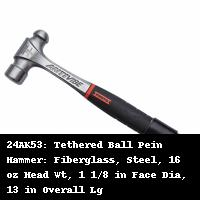
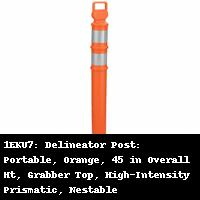
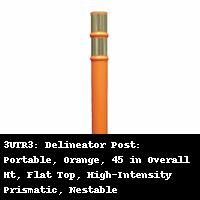
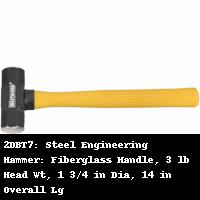
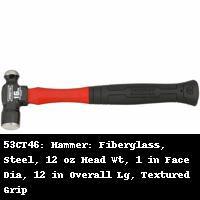

Total Image Time: 0.7401831150054932


In [308]:
import asyncio
import aiohttp
import pandas as pd
import time
from PIL import Image, ImageDraw, ImageFont
import io
import base64
from IPython.core.display import display, HTML

async def generate_thumbnail(image_url, code, name):
    async with aiohttp.ClientSession() as session:
        async with session.get(image_url) as resp:
            img_data = await resp.read()
            
    img = Image.open(io.BytesIO(img_data))
    img.thumbnail((200, 200))  # Adjust the size as needed for thumbnails

    draw = ImageDraw.Draw(img)
    text = f"{code}: {name}"
    font = ImageFont.load_default()  # Adjust the font and size here
    
    max_text_width = img.width - 10  # Max width for wrapping text
    lines = []
    words = text.split()
    while words:
        line = ''
        while words and draw.textsize(line + words[0], font=font)[0] <= max_text_width:
            line += words.pop(0) + ' '
        lines.append(line)
    wrapped_text = '\n'.join(lines)
    
    wrapped_text_width, wrapped_text_height = draw.textsize(wrapped_text, font=font)
    
    box_width = img.width
    box_height = wrapped_text_height + 10  # Adjust padding as needed
    
    draw.rectangle([(0, img.height - box_height), (img.width, img.height)], fill='black')
    
    text_x = (img.width - wrapped_text_width) / 2
    text_y = img.height - box_height + (box_height - wrapped_text_height) / 2  # Center vertically
    
    draw.text((text_x, text_y), wrapped_text, fill='white', font=font)
    
    buffered = io.BytesIO()
    img.save(buffered, format="JPEG")
    base_64_thumbnail_str = base64.b64encode(buffered.getvalue()).decode()

    return f"<td><img src='data:image/jpeg;base64,{base_64_thumbnail_str}'></td>"

async def main():
    start_time = time.time()
    
    image_strips = [
        await generate_thumbnail(item["Image URL"], item["Code"], df.loc[df['Code'] == item["Code"], 'Name'].iloc[0])
        for item in image_url_maps if item
    ]
    
    display(HTML("<table><tr>" + "".join(image_strips) + "</tr></table>"))
    print("Total Image Time:", time.time() - start_time)


# Execute the main coroutine directly in a Jupyter notebook cell
await main()


In [314]:
# import time
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from webdriver_manager.chrome import ChromeDriverManager
# from urllib.parse import urljoin
# from selenium import webdriver
# from bs4 import BeautifulSoup
# 
# def extract_reviews(html_content):
#     """
#     Extracts reviews from the given HTML content.
# 
#     Parameters:
#     - html_content (str): The HTML content to parse.
# 
#     Returns:
#     - List[dict]: A list of dictionaries, each containing the extracted review details.
#     """
#     if not html_content:
#         print("No HTML content to process.")
#         return []
# 
#     soup = BeautifulSoup(html_content, 'html.parser')
#     
#     # Extracting star rating
#     star_rating_container = soup.find('section', class_='pr-review-snapshot-block-snippet')
#     if star_rating_container:
#         star_rating = star_rating_container.find('div', class_='pr-snippet-stars')
#         star_rating_text = star_rating_container.find('div', class_='pr-snippet-rating-decimal').text.strip()
#         if star_rating:
#             star_rating_label = star_rating['aria-label']
#             print(f"Star Rating: {star_rating_label}, {star_rating_text}")
#         else:
#             print("Star Rating not found.")
#     else:
#         print("Star Rating container not found.")
# 
#     # Extracting recommendation percentage
#     recommendation_section = soup.find('section', class_='pr-review-snapshot-block-recommend')
#     if recommendation_section:
#         recommendation_percent = recommendation_section.find('span', class_='pr-reco-value').text.strip()
#         print(f"Recommendation Percentage: {recommendation_percent}")
#     else:
#         print("Recommendation section not found.")
# 
#     # Extracting reviews
#     reviews = soup.find_all('section', class_='pr-rd-content-block')
#     reviews_data = []
# 
#     for idx, review in enumerate(reviews, start=1):
#         print(f"\nProcessing review {idx}:")
# 
#         # Extracting review text
#         review_text = review.find('p', class_='pr-rd-description-text')
#         if review_text:
#             print("Review Text:", review_text.text.strip())
#         else:
#             print("Review Text not found.")
# 
#         # Adding review data
#         reviews_data.append({
#             'Star Rating': star_rating_label if star_rating else None,
#             'Rating Text': star_rating_text if star_rating_text else None,
#             'Review Text': review_text.text.strip() if review_text else None
#         })
# 
#     return reviews_data
# 
# 
# # Selenium setup
# options = Options()
# options.add_argument("--headless")
# options.add_argument("--disable-gpu")
# service = Service(ChromeDriverManager().install())
# driver = webdriver.Chrome(service=service, options=options)
# 
# def get_page_soup(url):
#     print(f"Getting page soup for URL: {url}")
#     driver.get(url)
#     time.sleep(1)  # Wait for the page to load
#     html = driver.page_source
#     return BeautifulSoup(html, 'html.parser')
# 
# def search_product(product_id):
#     print(f"Searching for product ID: {product_id}")
#     search_url = f'https://www.zoro.com/search?q={product_id}'
#     soup = get_page_soup(search_url)
# 
#     # Find the specific product link using a precise CSS selector
#     for a in soup.select('a.product-card-image__link'):
#         print(f"Checking link: {a['href']}")
#         if product_id.lower() in a['href'].lower():
#             product_url = urljoin(search_url, a['href'])
#             print(f"Found product URL: {product_url}")
#             return product_url
# 
#     print("Product URL not found.")
#     return None
# 
# def find_reviews_link(product_url):
#     print(f"Finding reviews link on product URL: {product_url}")
#     soup = get_page_soup(product_url)
# 
#     # Find the reviews link using a precise CSS selector
#     for a in soup.select('a'):
#         print(f"Checking link: {a['href']}")
#         if 'reviews' in a['href']:
#             reviews_url = urljoin(product_url, a['href'])
#             print(f"Found reviews URL: {reviews_url}")
#             return reviews_url
# 
#     print("Reviews URL not found.")
#     return None
# 
# def navigate_to_reviews(product_id):
#     start_time = time.time()
#     print(f"Navigating to reviews for product ID: {product_id}")
#     product_url = search_product(product_id)
#     if product_url:
#         reviews_url = find_reviews_link(product_url)
#         if reviews_url:
#             print(f"Navigating to reviews URL: {reviews_url}")
#             driver.get(reviews_url)
#             time.sleep(1)  # Wait for the reviews page to load
#             # Extract page source after page load
#             html_content = driver.page_source
# 
#             # Pass HTML content to extract_reviews function
#             reviews_data = extract_reviews(html_content)
# 
#             # Print extracted reviews data
#             print("\nExtracted Reviews:")
#             for review in reviews_data:
#                 print(review)
#         else:
#             print("Reviews URL not found.")
#     else:
#         print("Product URL not found.")
#     end_time = time.time()  # Record the end time
#     total_time_taken = end_time - start_time  # Calculate the total time taken
#     print(f"Total Time Taken: {total_time_taken:.2f} seconds")  # Display the total time taken
# 
# 
# 
# product_id = '1VCE8'
# reviews_received = navigate_to_reviews(product_id)
# 
# driver.quit()


Navigating to reviews for product ID: 1VCE8
Searching for product ID: 1VCE8
Getting page soup for URL: https://www.zoro.com/search?q=1VCE8
Checking link: /dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Found product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Finding reviews link on product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Getting page soup for URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Checking link: #main-content
Checking link: /safety/c/z1/
Checking link: /office-school-shipping-supplies/c/z9/
Checking link: /heating-cooling/c/30/
Checking link: /tools-machining/c/z2/
Checking link: /abrasives-polishers/c/1/
Checking link: /adhesives-tapes/c/4/
Checking link: /electrical-supplies/c/23/
Checking link: /ele

In [357]:
# from bs4 import BeautifulSoup
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options
# from webdriver_manager.chrome import ChromeDriverManager
# from urllib.parse import urljoin
# import time
# 
# def extract_reviews(html_content):
#     """
#     Extracts reviews from the given HTML content.
# 
#     Parameters:
#     - html_content (str): The HTML content to parse.
# 
#     Returns:
#     - List[dict]: A list of dictionaries, each containing the extracted review details.
#     """
#     if not html_content:
#         print("No HTML content to process.")
#         return []
# 
#     soup = BeautifulSoup(html_content, 'html.parser')
#     
#     # Initialize an empty list to hold the extracted reviews
#     reviews_data = []
#     
#     # Attempt to extract star rating and recommendation percentage
#     try:
#         # Star Rating
#         star_rating_container = soup.find('section', class_='pr-review-snapshot-block-snippet')
#         if star_rating_container:
#             star_rating = star_rating_container.find('div', class_='pr-snippet-stars')
#             star_rating_text = star_rating_container.find('div', class_='pr-snippet-rating-decimal').text.strip()
#             if star_rating:
#                 star_rating_label = star_rating['aria-label']
#                 print(f"Star Rating: {star_rating_label}, {star_rating_text}")
#             else:
#                 print("Star Rating not found.")
#         else:
#             print("Star Rating container not found.")
#         
#         # Recommendation Percentage
#         recommendation_section = soup.find('section', class_='pr-review-snapshot-block-recommend')
#         if recommendation_section:
#             recommendation_percent = recommendation_section.find('span', class_='pr-reco-value').text.strip()
#             print(f"Recommendation Percentage: {recommendation_percent}")
#         else:
#             print("Recommendation section not found.")
#     except AttributeError:
#         print("Error parsing review details.")
#     
#     # Extracting reviews
#     reviews = soup.find_all('section', class_='pr-rd-content-block')
#     for idx, review in enumerate(reviews, start=1):
#         print(f"\nProcessing review {idx}:")
#         
#         # Extracting review text
#         review_text = review.find('p', class_='pr-rd-description-text')
#         if review_text:
#             print("Review Text:", review_text.text.strip())
#         else:
#             print("Review Text not found.")
#         
#         # Constructing the review data dictionary
#         review_data = {
#             'Star Rating': star_rating_label if star_rating else None,
#             'Rating Text': star_rating_text if star_rating_text else None,
#             'Review Text': review_text.text.strip() if review_text else None
#         }
#         
#         # Add the constructed review data to the list
#         reviews_data.append(review_data)
#     
#     return reviews_data
# 
# # Selenium setup
# options = Options()
# options.add_argument("--headless")
# options.add_argument("--disable-gpu")
# service = Service(ChromeDriverManager().install())
# driver = webdriver.Chrome(service=service, options=options)
# 
# def get_page_soup(url):
#     """
#     Retrieves the page soup for the given URL using Selenium.
# 
#     Parameters:
#     - url (str): The URL to fetch.
# 
#     Returns:
#     - BeautifulSoup: The BeautifulSoup object of the page content.
#     """
#     print(f"Getting page soup for URL: {url}")
#     driver.get(url)
#     time.sleep(1)  # Wait for the page to load
#     html = driver.page_source
#     return BeautifulSoup(html, 'html.parser')
# 
# def search_product(product_id):
#     """
#     Searches for the product using the product ID and returns the product URL.
# 
#     Parameters:
#     - product_id (str): The product ID to search for.
# 
#     Returns:
#     - str: The URL of the product.
#     """
#     print(f"Searching for product ID: {product_id}")
#     search_url = f'https://www.zoro.com/search?q={product_id}'
#     soup = get_page_soup(search_url)
# 
#     # Find the specific product link using a precise CSS selector
#     for a in soup.select('a.product-card-image__link'):
#         print(f"Checking link: {a['href']}")
#         if product_id.lower() in a['href'].lower():
#             product_url = urljoin(search_url, a['href'])
#             print(f"Found product URL: {product_url}")
#             return product_url
# 
#     print("Product URL not found.")
#     return None
# 
# def find_reviews_link(product_url):
#     """
#     Finds the reviews link on the product URL.
# 
#     Parameters:
#     - product_url (str): The URL of the product.
# 
#     Returns:
#     - str: The URL of the reviews page.
#     """
#     print(f"Finding reviews link on product URL: {product_url}")
#     soup = get_page_soup(product_url)
# 
#     # Find the reviews link using a precise CSS selector
#     for a in soup.select('a'):
#         print(f"Checking link: {a['href']}")
#         if 'reviews' in a['href']:
#             reviews_url = urljoin(product_url, a['href'])
#             print(f"Found reviews URL: {reviews_url}")
#             return reviews_url
# 
#     print("Reviews URL not found.")
#     return None
# 
# def navigate_to_reviews(product_id):
#     """
#     Navigates to the reviews page of the product and extracts reviews.
# 
#     Parameters:
#     - product_id (str): The product ID to search for.
# 
#     Returns:
#     - List[dict]: A list of dictionaries containing the reviews.
#     """
#     start_time = time.time()
#     print(f"Navigating to reviews for product ID: {product_id}")
#     product_url = search_product(product_id)
#     if product_url:
#         reviews_url = find_reviews_link(product_url)
#         if reviews_url:
#             print(f"Navigating to reviews URL: {reviews_url}")
#             driver.get(reviews_url)
#             time.sleep(1)  # Wait for the reviews page to load
#             # Extract page source after page load
#             html_content = driver.page_source
# 
#             # Pass HTML content to extract_reviews function
#             reviews_data = extract_reviews(html_content)
#             print("reviews_data = ", reviews_data)    
#             # Print extracted reviews data
#             print("\nExtracted Reviews:")
#             for review in reviews_data:
#                 print(review)
#             end_time = time.time()  # Record the end time
#             total_time_taken = end_time - start_time  # Calculate the total time taken
#             print(f"Total Time Taken: {total_time_taken:.2f} seconds")     
#             return reviews_data    
#         else:
#             print("Reviews URL not found.")
#     else:
#         print("Product URL not found.")
#     end_time = time.time()  # Record the end time
#     total_time_taken = end_time - start_time  # Calculate the total time taken
#     print(f"Total Time Taken: {total_time_taken:.2f} seconds")  # Display the total time taken
# 
# # Example product ID to fetch reviews for
# product_id = '1VCE8'
# reviews_received = navigate_to_reviews(product_id)
# driver.quit()


Navigating to reviews for product ID: 1VCE8
Searching for product ID: 1VCE8
Getting page soup for URL: https://www.zoro.com/search?q=1VCE8
Checking link: /dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Found product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Finding reviews link on product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Getting page soup for URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Checking link: #main-content
Checking link: /safety/c/z1/
Checking link: /office-school-shipping-supplies/c/z9/
Checking link: /heating-cooling/c/30/
Checking link: /tools-machining/c/z2/
Checking link: /abrasives-polishers/c/1/
Checking link: /adhesives-tapes/c/4/
Checking link: /electrical-supplies/c/23/
Checking link: /ele

In [358]:
# import aiohttp
# import asyncio
# from bs4 import BeautifulSoup
# from urllib.parse import urljoin
# 
# async def fetch_html(session, url):
#     """
#     Fetches the HTML content from the given URL asynchronously.
# 
#     Parameters:
#     - session (ClientSession): The aiohttp client session.
#     - url (str): The URL to fetch.
# 
#     Returns:
#     - str: The HTML content of the page.
#     """
#     async with session.get(url) as response:
#         return await response.text()
# 
# async def get_page_soup(session, url):
#     """
#     Retrieves the page soup for the given URL using aiohttp.
# 
#     Parameters:
#     - session (ClientSession): The aiohttp client session.
#     - url (str): The URL to fetch.
# 
#     Returns:
#     - BeautifulSoup: The BeautifulSoup object of the page content.
#     """
#     print(f"Getting page soup for URL: {url}")
#     html = await fetch_html(session, url)
#     return BeautifulSoup(html, 'html.parser')
# 
# async def search_product(session, product_id):
#     """
#     Searches for the product using the product ID and returns the product URL.
# 
#     Parameters:
#     - session (ClientSession): The aiohttp client session.
#     - product_id (str): The product ID to search for.
# 
#     Returns:
#     - str: The URL of the product.
#     """
#     print(f"Searching for product ID: {product_id}")
#     search_url = f'https://www.zoro.com/search?q={product_id}'
#     soup = await get_page_soup(session, search_url)
# 
#     for a in soup.select('a.product-card-image__link'):
#         print(f"Checking link: {a['href']}")
#         if product_id.lower() in a['href'].lower():
#             product_url = urljoin(search_url, a['href'])
#             print(f"Found product URL: {product_url}")
#             return product_url
# 
#     print("Product URL not found.")
#     return None
# 
# async def find_reviews_link(session, product_url):
#     """
#     Finds the reviews link on the product URL.
# 
#     Parameters:
#     - session (ClientSession): The aiohttp client session.
#     - product_url (str): The URL of the product.
# 
#     Returns:
#     - str: The URL of the reviews page.
#     """
#     print(f"Finding reviews link on product URL: {product_url}")
#     soup = await get_page_soup(session, product_url)
# 
#     for a in soup.select('a'):
#         print(f"Checking link: {a['href']}")
#         if 'reviews' in a['href']:
#             reviews_url = urljoin(product_url, a['href'])
#             print(f"Found reviews URL: {reviews_url}")
#             return reviews_url
# 
#     print("Reviews URL not found.")
#     return None
# 
# async def extract_reviews(html_content):
#     """
#     Extracts reviews from the given HTML content.
# 
#     Parameters:
#     - html_content (str): The HTML content to parse.
# 
#     Returns:
#     - List[dict]: A list of dictionaries, each containing the extracted review details.
#     """
#     if not html_content:
#         print("No HTML content to process.")
#         return []
# 
#     soup = BeautifulSoup(html_content, 'html.parser')
# 
#     reviews_data = []
# 
#     try:
#         star_rating_container = soup.find('section', class_='pr-review-snapshot-block-snippet')
#         if star_rating_container:
#             star_rating = star_rating_container.find('div', class_='pr-snippet-stars')
#             star_rating_text = star_rating_container.find('div', class_='pr-snippet-rating-decimal').text.strip()
#             if star_rating:
#                 star_rating_label = star_rating['aria-label']
#                 print(f"Star Rating: {star_rating_label}, {star_rating_text}")
#             else:
#                 print("Star Rating not found.")
#         else:
#             print("Star Rating container not found.")
# 
#         recommendation_section = soup.find('section', class_='pr-review-snapshot-block-recommend')
#         if recommendation_section:
#             recommendation_percent = recommendation_section.find('span', class_='pr-reco-value').text.strip()
#             print(f"Recommendation Percentage: {recommendation_percent}")
#         else:
#             print("Recommendation section not found.")
#     except AttributeError:
#         print("Error parsing review details.")
# 
#     reviews = soup.find_all('section', class_='pr-rd-content-block')
#     for idx, review in enumerate(reviews, start=1):
#         print(f"\nProcessing review {idx}:")
# 
#         review_text = review.find('p', class_='pr-rd-description-text')
#         if review_text:
#             print("Review Text:", review_text.text.strip())
#         else:
#             print("Review Text not found.")
# 
#         review_data = {
#             'Star Rating': star_rating_label if star_rating else None,
#             'Rating Text': star_rating_text if star_rating_text else None,
#             'Review Text': review_text.text.strip() if review_text else None
#         }
# 
#         reviews_data.append(review_data)
# 
#     return reviews_data
# 
# async def navigate_to_reviews(product_id):
#     """
#     Navigates to the reviews page of the product and extracts reviews.
# 
#     Parameters:
#     - product_id (str): The product ID to search for.
# 
#     Returns:
#     - List[dict]: A list of dictionaries containing the reviews.
#     """
#     async with aiohttp.ClientSession() as session:
#         start_time = time.time()
#         print(f"Navigating to reviews for product ID: {product_id}")
#         product_url = await search_product(session, product_id)
#         if product_url:
#             reviews_url = await find_reviews_link(session, product_url)
#             if reviews_url:
#                 print(f"Navigating to reviews URL: {reviews_url}")
#                 html_content = await fetch_html(session, reviews_url)
#                 reviews_data = await extract_reviews(html_content)
#                 
#                 print("\nExtracted Reviews:")
#                 for review in reviews_data:
#                     print(review)
#                 
#                 return reviews_data
#             else:
#                 print("Reviews URL not found.")
#         else:
#             print("Product URL not found.")
# 
#         end_time = time.time()
#         total_time_taken = end_time - start_time
#         print(f"Total Time Taken: {total_time_taken:.2f} seconds")
# 
# # Example product ID to fetch reviews for
# product_id = '1VCE8'
# 
# # Run the asynchronous function
# await navigate_to_reviews(product_id)


Navigating to reviews for product ID: 1VCE8
Searching for product ID: 1VCE8
Getting page soup for URL: https://www.zoro.com/search?q=1VCE8
Product URL not found.
Product URL not found.
Total Time Taken: 0.07 seconds


In [362]:
import asyncio
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import nest_asyncio

nest_asyncio.apply()  # To enable nested event loops for Jupyter notebooks

def extract_reviews(html_content):
    """
    Extracts reviews from the given HTML content.

    Parameters:
    - html_content (str): The HTML content to parse.

    Returns:
    - List[dict]: A list of dictionaries, each containing the extracted review details.
    """
    if not html_content:
        print("No HTML content to process.")
        return None  # Return None when no HTML content is provided

    soup = BeautifulSoup(html_content, 'html.parser')

    # Initialize an empty list to hold the extracted reviews
    reviews_data = []

    # Attempt to extract star rating and recommendation percentage
    try:
        # Star Rating
        star_rating_container = soup.find('section', class_='pr-review-snapshot-block-snippet')
        if star_rating_container:
            star_rating = star_rating_container.find('div', class_='pr-snippet-stars')
            star_rating_text = star_rating_container.find('div', class_='pr-snippet-rating-decimal').text.strip()
            if star_rating:
                star_rating_label = star_rating['aria-label']
                print(f"Star Rating: {star_rating_label}, {star_rating_text}")
            else:
                print("Star Rating not found.")
        else:
            print("Star Rating container not found.")

        # Recommendation Percentage
        recommendation_section = soup.find('section', class_='pr-review-snapshot-block-recommend')
        if recommendation_section:
            recommendation_percent = recommendation_section.find('span', class_='pr-reco-value').text.strip()
            print(f"Recommendation Percentage: {recommendation_percent}")
        else:
            print("Recommendation section not found.")
    except AttributeError:
        print("Error parsing review details.")

    # Extracting reviews
    reviews = soup.find_all('section', class_='pr-rd-content-block')
    if reviews:
        for idx, review in enumerate(reviews, start=1):
            print(f"\nProcessing review {idx}:")
            # Extracting review text
            review_text = review.find('p', class_='pr-rd-description-text')
            if review_text:
                print("Review Text:", review_text.text.strip())
            else:
                print("Review Text not found.")

            # Constructing the review data dictionary
            review_data = {
                'Star Rating': star_rating_label if star_rating else None,
                'Rating Text': star_rating_text if star_rating_text else None,
                'Review Text': review_text.text.strip() if review_text else None
            }

            # Add the constructed review data to the list
            reviews_data.append(review_data)

    else:
        print("No reviews found on the page.")

    return reviews_data if reviews_data else None  # Return None if no reviews were extracted


# Define the synchronous functions
def get_page_soup(url, driver):
    print(f"Getting page soup for URL: {url}")
    driver.get(url)
    time.sleep(1)  # Wait for the page to load
    html = driver.page_source
    return BeautifulSoup(html, 'html.parser')

def search_product(product_id, driver):
    print(f"Searching for product ID: {product_id}")
    search_url = f'https://www.zoro.com/search?q={product_id}'
    soup = get_page_soup(search_url, driver)

    for a in soup.select('a.product-card-image__link'):
        print(f"Checking link: {a['href']}")
        if product_id.lower() in a['href'].lower():
            product_url = urljoin(search_url, a['href'])
            print(f"Found product URL: {product_url}")
            return product_url

    print("Product URL not found.")
    return None

def find_reviews_link(product_url, driver):
    print(f"Finding reviews link on product URL: {product_url}")
    soup = get_page_soup(product_url, driver)

    for a in soup.select('a'):
        print(f"Checking link: {a['href']}")
        if 'reviews' in a['href']:
            reviews_url = urljoin(product_url, a['href'])
            print(f"Found reviews URL: {reviews_url}")
            return reviews_url

    print("Reviews URL not found.")
    return None

# Define the asynchronous function
async def navigate_to_reviews(product_id):
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)

    start_time = time.time()
    print(f"Navigating to reviews for product ID: {product_id}")
    product_url = search_product(product_id, driver)
    if product_url:
        reviews_url = find_reviews_link(product_url, driver)
        if reviews_url:
            print(f"Navigating to reviews URL: {reviews_url}")
            driver.get(reviews_url)
            await asyncio.sleep(1)  # Wait for the reviews page to load
            html_content = driver.page_source
            reviews_data = extract_reviews(html_content)

            print("\nExtracted Reviews:")
            for review in reviews_data:
                print(review)

            driver.quit()
            end_time = time.time()
            total_time_taken = end_time - start_time
            print(f"Total Time Taken: {total_time_taken:.2f} seconds")
            return reviews_data
        else:
            print("Reviews URL not found.")
    else:
        print("Product URL not found.")

    driver.quit()
    end_time = time.time()
    total_time_taken = end_time - start_time
    print(f"Total Time Taken: {total_time_taken:.2f} seconds")
    return None

async def fetch_reviews_for_product_ids(product_ids):
    tasks = [navigate_to_reviews(product_id) for product_id in product_ids]
    results = await asyncio.gather(*tasks)
    for product_id, result in zip(product_ids, results):
        print(f"Reviews for {product_id}: {result}")

# # Example list of product IDs
# product_ids = ['1VCE8', '2ABC9', '3XYZ0', '4LMN1', '5PQR2']
# 
# # Fetch reviews concurrently
# await fetch_reviews_for_product_ids(product_ids)


Navigating to reviews for product ID: 1VCE8
Searching for product ID: 1VCE8
Getting page soup for URL: https://www.zoro.com/search?q=1VCE8
Checking link: /dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Found product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Finding reviews link on product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Getting page soup for URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Checking link: #main-content
Checking link: /safety/c/z1/
Checking link: /office-school-shipping-supplies/c/z9/
Checking link: /heating-cooling/c/30/
Checking link: /tools-machining/c/z2/
Checking link: /abrasives-polishers/c/1/
Checking link: /adhesives-tapes/c/4/
Checking link: /electrical-supplies/c/23/
Checking link: /ele

In [365]:
async def extract_product_codes(image_url_maps):
    """
    Extracts product codes from a list of image URL maps.

    Parameters:
    - image_url_maps (list): A list of dictionaries containing 'Code' and 'Image URL' keys.

    Returns:
    - List[str]: A list of product codes.
    """
    product_codes = []
    for image_url_map in image_url_maps:
        product_code = image_url_map['Code']
        product_codes.append(product_code)
    return product_codes


In [363]:
import asyncio
import concurrent.futures
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import time

async def fetch_reviews_for_product_ids(product_ids):
    tasks = [navigate_to_reviews(product_id) for product_id in product_ids]
    results = await asyncio.gather(*tasks)
    for product_id, result in zip(product_ids, results):
        print(f"Reviews for {product_id}: {result}")

# # Example list of product IDs
# product_ids = ['1VCE8', '2ABC9', '3XYZ0', '4LMN1', '5PQR2']
# 
# # Fetch reviews concurrently
# await fetch_reviews_for_product_ids(product_ids)

Navigating to reviews for product ID: 1VCE8
Searching for product ID: 1VCE8
Getting page soup for URL: https://www.zoro.com/search?q=1VCE8
Checking link: /dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Found product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Finding reviews link on product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Getting page soup for URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Checking link: #main-content
Checking link: /safety/c/z1/
Checking link: /office-school-shipping-supplies/c/z9/
Checking link: /heating-cooling/c/30/
Checking link: /tools-machining/c/z2/
Checking link: /abrasives-polishers/c/1/
Checking link: /adhesives-tapes/c/4/
Checking link: /electrical-supplies/c/23/
Checking link: /ele

In [380]:
import asyncio
from typing import List, Optional


async def fetch_reviews_for_product_id(product_id: str) -> Optional[dict]:
    # Your existing code to fetch reviews for a single product ID
    # Assuming it returns a dictionary with review details or None if no reviews found
    reviews = await navigate_to_reviews(product_id)
    return reviews

async def generate_product_reviews(image_url_maps: List[dict]) -> Optional[dict]:
    reviews_dict = {}

    # Loop through each item in image_url_maps
    for item in image_url_maps:
        product_id = item['Code']
        reviews = await fetch_reviews_for_product_id(product_id)
        reviews_dict[product_id] = reviews

    return reviews_dict



In [383]:
# image_url_maps[0]['Code'] = '1VCE8'
reviews_dict = await generate_product_reviews(image_url_maps)
print("THE REVIEW DICT: ", reviews_dict)

Navigating to reviews for product ID: 1VCE8
Searching for product ID: 1VCE8
Getting page soup for URL: https://www.zoro.com/search?q=1VCE8
Checking link: /dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Found product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Finding reviews link on product URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Getting page soup for URL: https://www.zoro.com/dayton-standard-duty-industrial-fan-24-non-oscillating-115vac-38506200-cfm-1vce8/i/G1828802/
Checking link: #main-content
Checking link: /safety/c/z1/
Checking link: /office-school-shipping-supplies/c/z9/
Checking link: /heating-cooling/c/30/
Checking link: /tools-machining/c/z2/
Checking link: /abrasives-polishers/c/1/
Checking link: /adhesives-tapes/c/4/
Checking link: /electrical-supplies/c/23/
Checking link: /ele

## Enhance user experience with Chatbot

#### Generating detailed overview based on customer reviews of products sister company Zoro when the same product is sold.
LangChain's [ConversationBufferMemory](https://python.langchain.com/docs/use_cases/question_answering/chat_vector_db) class provides a way to capture conversational memory for LLM chat applications. We will have Claude being able to retrieve context through conversational memory using the prompt template. Note that this time our prompt template includes a {chat_history} variable where our chat history will be included to the prompt.

The prompt template has both conversation memory as well as chat history as inputs along with the human input. Notice how the prompt also instructs Claude to not answer questions which it does not have the context for. This helps reduce hallucinations which is extremely important when creating end user facing applications which need to be factual.


![Architecture](./images/chatbot_products.png)

In [405]:
# # chat_prompt1 = "Show me specific reviews that talk about the quality of the products."
# # chat_prompt2 = "What do people like about the products?"
# 
# from langchain.chains import ConversationalRetrievalChain
# from langchain.memory import ConversationBufferMemory
# from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT
# 
# chat_history = [" "]
# memory_chain = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
# conversation = ConversationalRetrievalChain.from_llm(
#     llm=llm, 
#     retriever=vectorstore_faiss_doc.as_retriever(), 
#     memory=memory_chain,
#     condense_question_prompt=CONDENSE_QUESTION_PROMPT,
#     #verbose=True, 
#     chain_type='stuff', # 'refine',
#     #max_tokens_limit=300
# )
# 
# # Generate detailed reviews based on customer reviews of specific clothing in product catalog
# # 
# # try:
# #     chat_history = []
# #     print("********************chat_history", chat_history)
# #     chat_res1 = conversation.run({'question': chat_prompt1, 'chat_history': chat_history })
# #     print_ww(chat_res1)
# #     chat_history.append([chat_prompt1, chat_res1])
# #     if response_json:
# #         # print("**********response_json['products']", response_json['products'])
# #         chat_history.append(response_json['products'])
# #         # print("********************chat_history", chat_history)
# #     if reviews_dict:
# #         # print("**********reviews_dict", reviews_dict)
# #         chat_history.append(reviews_dict)
# #         # print("********************chat_history", chat_history)
# # except ValueError as error:
# #     if  "AccessDeniedException" in str(error):
# #         class StopExecution(ValueError):
# #             def _render_traceback_(self):
# #                 pass
# #         raise StopExecution        
# #     else:
# #         raise error

********************chat_history []
 Based on the provided context, here are two reviews that talk about the quality of the products:

For the 4KN31 TOUGH GUY Trash Bags:

"These trash bags are very thin and flimsy. I've had several rip down the sides just from normal
household trash. Would not recommend if you want durable trash bags."

For the 11C554 APPROVED VENDOR Instant Canopy:

"I was impressed by the quality of this instant canopy. The polyester material seems durable and
protected us from sun and light rain during an outdoor event. The steel frame is sturdy and easy to
set up and take down."


In [408]:
# from langchain.chains.chat_vector_db.prompts import QA_PROMPT
# 
# 
# async def process_chat_question(question, clear_history=False):
#     # llm=llm
#     # retriever=vectorstore_faiss_doc.as_retriever()
#     # memory_chain = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
#     try:
#         if clear_history:
#             chat_history.clear()  # Clear chat history if specified
# 
#         context = {
#             'question': question,
#             'chat_history': chat_history
#         }
# 
#         # Run conversation with provided context
#         chat_res = await conversation.run(**context)
#         print_ww(chat_res)  # Assuming print_ww is defined elsewhere for specific logging/printing
# 
#         # Append the chat prompt and result to history
#         chat_history.append([question, chat_res])
# 
#         # Optionally add response_json['products'] and reviews_dict to chat history
#         if response_json:
#             chat_history.append(response_json['products'])
# 
#         if reviews_dict:
#             chat_history.append(reviews_dict)
# 
#         return str(chat_res)  # Return chat response as a string
# 
#     except ValueError as error:
#         if "AccessDeniedException" in str(error):
#             class StopExecution(ValueError):
#                 def _render_traceback_(self):
#                     pass
#             raise StopExecution
#         else:
#             raise error


In [409]:
# question="what are the products you have recommended so far?"
# process_chat_question(question)

<coroutine object process_chat_question at 0x1310e0dd0>

In [420]:
# HERE IS THE CONVERSATION
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT

chat_history = [" "]
memory_chain = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversation = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    retriever=vectorstore_faiss_doc.as_retriever(), 
    memory=memory_chain,
    condense_question_prompt=CONDENSE_QUESTION_PROMPT,
    chain_type='stuff',  # 'refine',
)

# Define a function to process the chat question
def process_chat_question(question, clear_history=False):
    try:
        if clear_history:
            chat_history.clear()  # Clear chat history if specified

        context = {
            'question': question,
            'chat_history': chat_history
        }

        # Run conversation with provided context synchronously
        chat_res = conversation.run(**context)

        # Append the chat prompt and result to history
        chat_history.append([question, chat_res])

        # Optionally add response_json['products'] and reviews_dict to chat history
        if response_json:
            chat_history.append(response_json['products'])

        if reviews_dict:
            chat_history.append(reviews_dict)

        return str(chat_res)  # Return chat response as a string

    except ValueError as error:
        if "AccessDeniedException" in str(error):
            class StopExecution(ValueError):
                def _render_traceback_(self):
                    pass
            raise StopExecution
        else:
            raise error

# Example usage:
question = ("I am looking for information about product 1VCE8")
response = process_chat_question(question, clear_history=True)  # Specify clear_history as needed
print(response) 


 Unfortunately I do not have enough context to know anything about a product called 1VCE8 based on the information provided. The product descriptions provided are for 426P11, 23NT18, 61VD28, and 426P08, but there is no information provided about a product called 1VCE8. Since I don't have any details about what 1VCE8 refers to, I don't have enough information to provide any specifics about it. I'm sorry I couldn't be more helpful without additional context about the 1VCE8 product.


In [404]:
 
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.chains.conversational_retrieval.prompts import CONDENSE_QUESTION_PROMPT

chat_history = [" "]
memory_chain = ConversationBufferMemory(memory_key="chat_history", return_messages=True)
conversation = ConversationalRetrievalChain.from_llm(
    llm=llm, 
    retriever=vectorstore_faiss_doc.as_retriever(), 
    memory=memory_chain,
    condense_question_prompt=CONDENSE_QUESTION_PROMPT,
    #verbose=True, 
    chain_type='stuff', # 'refine',
    #max_tokens_limit=300
)

In [419]:
chat_prompt2 = "What do people like about those product?"
try:
    print("Chat History: " , chat_history, "\n")
    chat_res2 = conversation.run({'question': chat_prompt2 + "Do Not Answer if embeddings does not return anything.", 'chat_history': chat_history }) # + " Answer even if embeddings does not return anything."
    print_ww("chat_res2: ", chat_res2)
    chat_history.append([chat_prompt2, chat_res2])
except ValueError as error:
    if  "AccessDeniedException" in str(error):
        class StopExecution(ValueError):
            def _render_traceback_(self):
                pass
        raise StopExecution        
    else:
        raise error

Chat History:  [' ', ['I am looking for information about product 1VCE8', " Unfortunately I do not have enough context to know anything about a product called 1VCE8 based on the information provided. The product descriptions provided are for 426P11, 23NT18, 61VD28, and 426P08, but there is no information provided about a product called 1VCE8. Since I don't have any details about what 1VCE8 refers to, I don't have enough information to provide any specifics about it. I'm sorry I couldn't be more helpful without additional context about the 1VCE8 product."], [{'product': 'Tethered Ball Pein Hammer: Fiberglass, Steel, 16 oz Head Wt, 1 1/8 in Face Dia, 13 in Overall Lg', 'code': '24AK53'}, {'product': 'Delineator Post: Portable, Orange, 45 in Overall Ht, Grabber Top, High-Intensity Prismatic, Nestable', 'code': '1EKU7'}, {'product': 'Delineator Post: Portable, Orange, 45 in Overall Ht, Flat Top, High-Intensity Prismatic, Nestable', 'code': '3UTR3'}, {'product': 'Steel Engineering Hammer: F

ValueError: Error raised by inference endpoint: An error occurred (ValidationException) when calling the InvokeModel operation: Malformed input request: expected minLength: 1, actual: 0, please reformat your input and try again.

#### Customer order history semantic searches

Generating size and color recommendations based on customer's order history. This will help to provide curated content to the customer

In [164]:
#THIS IS NOT SOMETHING THAT CAN BE EMULATED UNTIL THE USER LOGIN IS SET UP AND THE FUNCTION IS NOT YET DEFINED AS THIS IS NOT NECESSARILY RELEVANT TO GRIANGER ORDERS.

from langchain.indexes.vectorstore import VectorStoreIndexWrapper


wrapper_store_faiss = VectorStoreIndexWrapper(vectorstore=vectorstore_faiss_doc)
query_embedding = bedrock_embeddings.embed_query(customer_input)
np.array(query_embedding)

chat_prompt3 = "What size and color should I wear?"
chat_res3 = wrapper_store_faiss.query(question= chat_prompt3 + " based on order history for customer with id " + customer_id, llm=llm)
print_ww(chat_res3)

 Unfortunately I do not have enough context to determine what size and color coveralls a specific
customer with ID 2 should wear. The provided information includes details about different sizes and
colors of Red Kap coveralls, but does not indicate anything about a particular customer's order
history or sizing needs. Without more specific information about a customer's previous orders or
measurements, I cannot recommend a particular size and color they should wear.


## Showing final products based on customer style selection 

Continuing on our architectural pattern we will change the prompt template and leverage the LLM to generate the `recommended` products based on the user selection and weather and other details. The key extraction entities will be 

1. Leverage the customer initial prompt to generate the relevant ids
2. Extract the relevant products from the vector store
3. Physical ID for the products needed



![Architecture](./images/other_products.png)

In [174]:
selected_style = recommendations[3]
print(selected_style)

selected_style = recommendations[0]
print(selected_style)

# Fetch the response from qa2
try:
    print(" GETTING THE RESPONSE: "),
    response = qa({chat_res2: selected_style})
    print(" THIS IS THE RESPONSE: ", response)
except AttributeError as e:
    print("AttributeError:", e)
    print("qa2 configuration:", chat_res2)
    print("qa2 retriever:", chat_res2.retriever)
    print("Input type:", type(selected_style))
    
# Print the entire response to see its structure
print(response)

# Check if 'result' is in the response
if 'result' in response:
    cart_items = response['result']
    print_ww(cart_items)
else:
    print("Error: 'result' key not found in the response. Response content:")
    print(response)


('Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 6, 1 PR', '21A645')
('Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR', '21A652')
 GETTING THE RESPONSE: 


ValueError: Missing some input keys: {'query'}

In [55]:
products = json.loads(re.findall('<products>(.*?)</products>', cart_items, re.DOTALL)[0])
products

[{'product': 'Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 6, 1 PR These half rubber-dipped neoprene boots are flexible and form-fitting for a snug, secure fit. They have a waterproof rubber coating that covers the bottom half of the outside of the boot. Knee-height boots protect the foot, lower leg, and calf to just below the knee. These insulated boots are worn when users are exposed to cold, wet conditions and below-freezing temperatures.',
  'physical_id': '21A645'},
 {'product': 'Rubber Boot: Cold-Insulated/Electrical Hazard (EH)/Oil-Resistant Sole/Plain Toe/Waterproof, 13, 1 PR These half rubber-dipped neoprene boots are flexible and form-fitting for a snug, secure fit. They have a waterproof rubber coating that covers the bottom half of the outside of the boot. Knee-height boots protect the foot, lower leg, and calf to just below the knee. These insulated boots are worn when users are exposed to cold, wet conditions and below-freezi

In [56]:
from PIL import Image
from IPython import display
import requests
import urllib.parse

cart_item_strip = ""
for product in products:
    url = "https://sagemaker-example-files-prod-us-east-1.s3.us-east-1.amazonaws.com/datasets/image/howser-bedrock/data/aistylist/images/products/" + urllib.parse.quote(product['physical_id'].strip(), safe='', encoding=None, errors=None) + ".jpg"
    # im = Image.open(requests.get(url, stream=True).raw)
    cart_item_strip += "<td><img src='"+ url + "'></td>"
display.display(display.HTML("<table><tr>" + cart_item_strip +"</tr></table>"))

,,,


## Integrating DIY Agents to associate external APIs and databases
### Using ReAct: Synergizing Reasoning and Acting in Language Models Framework
Large language models can generate both explanations for their reasoning and task-specific responses in an alternating fashion. 

Producing reasoning explanations enables the model to infer, monitor, and revise action plans, and even handle unexpected scenarios. The action step allows the model to interface with and obtain information from external sources such as knowledge bases or environments.

The ReAct framework could enable large language models to interact with external tools to obtain additional information that results in more accurate and fact-based responses. Here we will leverage the user prompt and perform the following actions
1. Extract the city 
2. Get weather information
3. Search our product catalog using semantic search to find relevant products
4. Display the products for user to add to cart

![Architecture](./images/weather.png)

In [ ]:
import os
import python_weather

async def getweather(city):
  # declare the client. the measuring unit used defaults to the metric system (celcius, km/h, etc.)
  async with python_weather.Client(unit=python_weather.IMPERIAL) as client:
    # fetch a weather forecast from a city
    weather = await client.get(city)
    
    # returns the current day's forecast temperature (int)
    return weather.current

## Accessory recommendations 

We will provide  accessory recommendations based on location provided in customer input

In [ ]:
await getweather(entity_extraction_result[2])

In [ ]:
if accessory_response:
    accessories = re.findall('<style>(.*?)</style>', accessory_response)
    accessories_items = qa2({"query": ', '.join(accessories)})['result']
    accessories_items = json.loads(re.findall('<products>(.*?)</products>', accessories_items, re.DOTALL)[0])
    accessory_strip = ""
    for accessory in accessories_items:
        url = "https://sagemaker-example-files-prod-us-east-1.s3.us-east-1.amazonaws.com/datasets/image/howser-bedrock/data/aistylist/images/products/" + urllib.parse.quote(accessory['physical_id'].strip(), safe='', encoding=None, errors=None) + ".jpg"
        accessory_strip += "<td><img src='"+ url + "'></td>"
    display.display(display.HTML("<table><tr>" + accessory_strip +"</tr></table>"))

In [ ]:
import asyncio
accessory_response = None
if attributes["location"]:
    current_weather = await getweather(entity_extraction_result[2])
    accessory_input = "Suggest list of accessories based on the weather and the selected style. It is " + current_weather.description + " with temperature at " + str(current_weather.temperature) +" degrees fahrenheit.\n Selected Style: " + recommendations[0]
    accessory_response = qa({"query": accessory_input})['result']
    print_ww(accessory_response)

## Simulate the order check out

Add a customer data table to complete the order transaction. This information provides the shipping address for the outfit order.

In [ ]:
customer_table=[{"id": 1, "first_name": "John", "last_name": "Doe", "age": 35, "address": "123 Bedrock st, California 90210"},
  {"id": 2, "first_name": "Jane", "last_name": "Smith", "age": 27, "address": "234 Sagemaker drive, Texas 12345"},
  {"id": 3, "first_name": "Bob", "last_name": "Jones", "age": 42, "address": "111 DeepRacer ct, Virginia 55555"},
  {"id": 4, "first_name": "Sara", "last_name": "Miller", "age": 29, "address": "222 Robomaker ave, New Yotk 13579"},
  {"id": 5, "first_name": "Mark", "last_name": "Davis", "age": 31, "address": "444 Transcribe blvd, Florida 02468"},
  {"id": 6, "first_name": "Laura", "last_name": "Wilson", "age": 24, "address": "555 CodeGuru st, California 98765" },
  {"id": 7, "first_name": "Steve", "last_name": "Moore", "age": 36, "address": "456 DeepLens st, Texas 11223"},
  {"id": 8, "first_name": "Michelle", "last_name": "Chen", "age": 22, "address": "642 DeepCompose st, Colorado 33215"},
  {"id": 9, "first_name": "David", "last_name": "Lee", "age": 29, "address": "777 S3 st, California 99567"},
  {"id": 10, "first_name": "Jessica", "last_name": "Brown", "age": 18, "address": "909 Ec st, Utah 43210"}]

def address_lookup(id):
    for customer in customer_table:
        if customer["id"] == int(id):
            return customer
        
    return None

print(address_lookup(customer_id)["address"])